In [1]:
%%configure -f
{ "conf":{
    "spark.pyspark.python": "python3",
    "spark.pyspark.virtualenv.enabled": "true",
    "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
    "spark.pyspark.virtualenv.type":"native",
    "spark.dynamicAllocation.enabled":"true",
    "spark.shuffle.service.enabled":"true",
    "spark.dynamicAllocation.minExecutors":"8",
    "spark.sql.sources.partitionOverwriteMode":"dynamic",
    "spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation":"true"
}
}

In [2]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("seaborn")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1617628379427_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("2_analysis").enableHiveSupport().getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
from datetime import datetime

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import StringIndexer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')
figsize = (10, 6)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Collect all the data
dfs_matches_stats = spark.sql('SELECT * FROM r6s_datapeek.matches_stats').persist()
dfs_matches_stats.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1588833

## Overall view on the data

In [6]:
fig,ax = plt.subplots(figsize = figsize)
dfs_matches_stats.groupBy(['date']).agg(F.count('matchid').alias('count_matches')).toPandas().plot(ax=ax, x='date',y='count_matches')
plt.xlabel("Day")
plt.ylabel("Count of matches")
fig.tight_layout()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

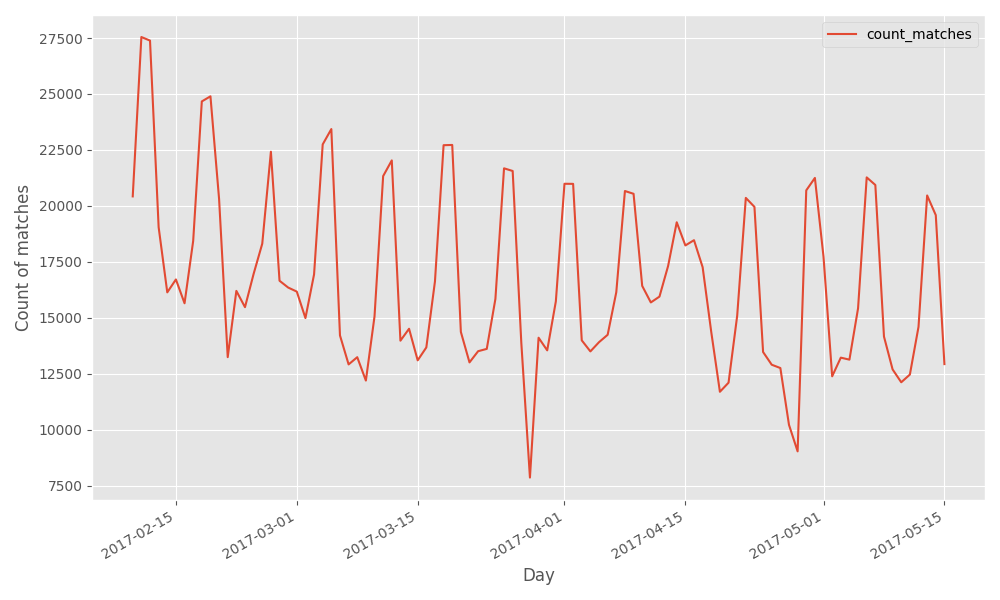

In [7]:
%matplot plt

In [8]:
# Get the number of rounds available
dfs_matches_stats.select(['max_roundnumber']).groupBy().sum().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(sum(max_roundnumber)=9187971)]

In [9]:
# compute some stats per week, map, platform and mode
dfp_repartition_matches = dfs_matches_stats.groupBy(['weekdate', 'mapname', 'platform', 'gamemode']).agg(F.count('matchid').alias('count_matches')).toPandas()
dfp_repartition_matches_sum = dfp_repartition_matches.groupby(['weekdate']).sum()['count_matches']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
categories = ['gamemode', 'platform']
fig,ax = plt.subplots(figsize = figsize)
count_plot = 1
for key in categories:
    print(key)
    ax=plt.subplot(len(categories), 1,count_plot)
    dfp_tmp = pd.pivot_table(dfp_repartition_matches, columns = [key], index = ['weekdate'], values = ['count_matches'], aggfunc = np.sum)
    dfp_tmp.columns = [elt[1] for elt in dfp_tmp.columns]
    dfp_tmp = dfp_tmp.div(dfp_repartition_matches_sum, axis=0)
    dfp_tmp.plot(ax=ax, kind='bar', stacked=True)
    plt.xticks(rotation=45)
    plt.xlabel("Week")
    plt.ylabel("Part of matches")
    count_plot+=1
fig.tight_layout()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

gamemode
platform

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

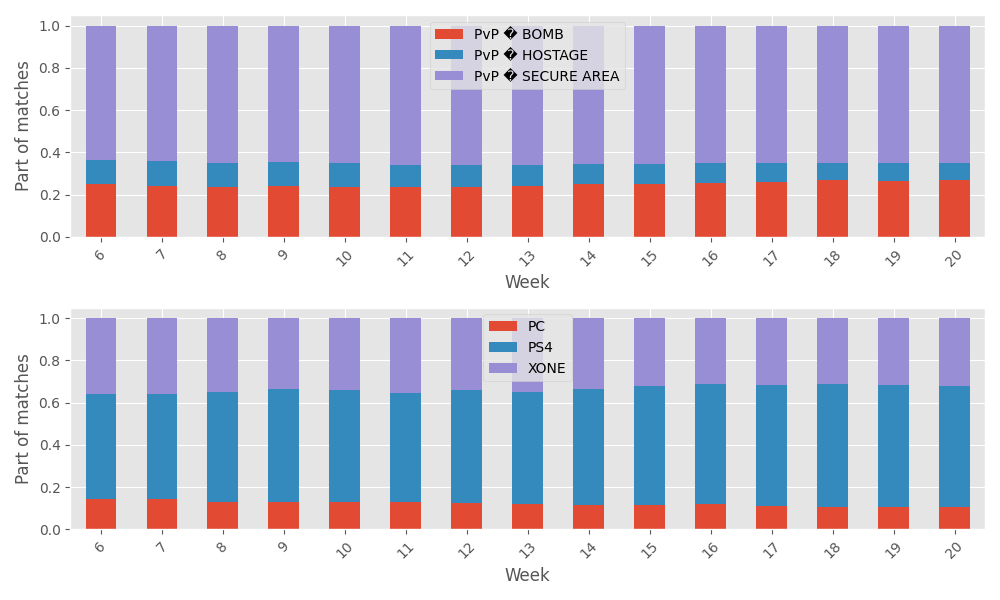

In [11]:
%matplot plt

## Work on the match quality

In [12]:
# Determine the number of good match
dfs_matches_stats = dfs_matches_stats.withColumn('flag_match_quality', 
                                                 F.when((F.col('team0_startsize') == 5) & (F.col('team1_startsize') == 5) & ((F.col('team0_deltasize') < 0) | (F.col('team1_deltasize') < 0)),'Ragequit')
                                                 .when((F.col('team0_startsize') == 5) & (F.col('team1_startsize') == 5)  & (F.col('team0_changed') == 0) & (F.col('team1_changed') == 0) & (F.col('max_roundnumber') % F.col('max_count_rows') == 0), 'Good')
                                                 .otherwise('Bad'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
dfs_matches_stats.groupBy(['flag_match_quality']).agg(F.count('matchid').alias('count_matches')).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  flag_match_quality  count_matches
0           Ragequit         429725
1                Bad         994286
2               Good         164822

In [14]:
dfp_matches_stats_sample = dfs_matches_stats.sample(False, 0.1, 0).limit(100).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
dfp_matches_stats_sample.iloc[1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

matchid                                                                     120266621
platform                                                                          PS4
mapname                                                                         HOUSE
gamemode                                                            PvP � SECURE AREA
max_roundnumber                                                                     4
count_rows                                                                         37
team0_role_firstround                                                        Attacker
team1_role_firstround                                                        Defender
team0_user_attributes_firstround    [[Silver, 53], [Gold, 59], [Gold, 29], [Gold, ...
team1_user_attributes_firstround    [[Unranked, 127], [Unranked, 105], [Unranked, ...
team0_user_attributes_lastround     [[Silver, 53], [Gold, 59], [Gold, 96], [Gold, ...
team1_user_attributes_lastround     [[Unranked, 105], 

## Build a predictor

In [16]:
# Collect the various categories
dict_categories = {
    'mapname' : dfp_repartition_matches['mapname'].unique().tolist(),
    'gamemode' : dfp_repartition_matches['gamemode'].unique().tolist(),
    'platform' : dfp_repartition_matches['platform'].unique().tolist()
}

teamid_reference = 0
teamid_opponent = 1 if teamid_reference == 0 else 0

skillranks = ['Unranked', 'Copper', 'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
dfs_mldata = dfs_matches_stats.filter(F.col('flag_match_quality') != 'Bad').persist()
dfs_mldata.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

594547

In [18]:
# Build the features related to the users
dfs_mldata = dfs_mldata.withColumn('features_skillrank', F.concat(F.col(f'team{teamid_reference}_skillranks'), F.col(f'team{teamid_opponent}_skillranks')))
dfs_mldata = dfs_mldata.withColumn('features_level', F.array(F.col(f'team{teamid_reference}_meanlevel'),F.col(f'team{teamid_reference}_stdlevel'), F.col(f'team{teamid_opponent}_meanlevel'),F.col(f'team{teamid_opponent}_stdlevel')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Build the features related to the matches (platform, mapname, gamemode) , by an encoding
indexer_platform = StringIndexer(inputCol="platform", outputCol="platform_index").fit(dfs_mldata)
indexer_mapname = StringIndexer(inputCol="mapname", outputCol="mapname_index").fit(dfs_mldata)
indexer_gamemode = StringIndexer(inputCol="gamemode", outputCol="gamemode_index").fit(dfs_mldata)
indexer_rolereference = StringIndexer(inputCol=f"team{teamid_reference}_role_firstround", outputCol="teamreference_role_firstround_index").fit(dfs_mldata)
indexer_patches = StringIndexer(inputCol=f"patch", outputCol="patch_index").fit(dfs_mldata)

dfs_mldata = indexer_platform.transform(dfs_mldata)
dfs_mldata = indexer_mapname.transform(dfs_mldata)
dfs_mldata = indexer_gamemode.transform(dfs_mldata)
dfs_mldata = indexer_rolereference.transform(dfs_mldata)
dfs_mldata = indexer_patches.transform(dfs_mldata)

dfs_mldata = dfs_mldata.withColumn('features_match', F.array(F.col('patch_index'), F.col(f'platform_index'), F.col(f'mapname_index'), F.col(f'gamemode_index'), F.col('teamreference_role_firstround_index')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
from pyspark.ml.linalg import Vectors, VectorUDT

build_features = F.udf(lambda v: Vectors.dense(v), VectorUDT())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
dfs_mldata = dfs_mldata.withColumn('features', F.concat(F.col(f'features_skillrank'), F.col(f'features_level'), F.col('features_match')))
dfs_mldata = dfs_mldata.withColumn('features', build_features(F.col('features')))
dfs_mldata = dfs_mldata.withColumn('label', F.col('teamreference_won'))

dfs_mldata = dfs_mldata.select(['matchid','features', 'label'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
features = []
for teamid in [teamid_reference,teamid_opponent]:
    for skillrank in skillranks:
        features.append(f'team{teamid}_count_players_ranked-{skillrank.lower()}')
        
features += [f'team{teamid_reference}_meanlevel', f'team{teamid_reference}_stdlevel', f'team{teamid_opponent}_meanlevel',f'team{teamid_opponent}_stdlevel']
features += ['patch_cat', 'platform_cat', 'mapname_cat', 'gamemode_index', 'teamreference_startrole']   

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
dfs_mldata.sample(False, 0.1, 0).limit(100).toPandas().iloc[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

matchid                                            1280702261
features    [3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
label                                                       1
Name: 0, dtype: object

In [24]:
dfs_training, dfs_testing = dfs_mldata.randomSplit([0.8, 0.2], seed=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator\

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Get the range of the paramter based on the docs https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html#pyspark.ml.regression.RandomForestRegressor
rf = RandomForestRegressor()
paramGrid = ParamGridBuilder()\
.addGrid(rf.maxBins, [8, 64, 128])\
.addGrid(rf.maxDepth, [4, 16])\
.addGrid(rf.numTrees, [2, 4, 16, 256])\
.build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Execute a grdi search based on the parameters selected before
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           trainRatio=0.9, 
                           seed=0)
model = tvs.fit(dfs_training)
# model = rf.fit(dfs_training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# diplay the features importance
dict_features_importance = {
    'value' : model.featureImportances,
    'name' : features
}

dfp_features_importance = pd.DataFrame(dict_features_importance).set_index(['name']).sort_values(['value'], ascending=True)
fig,ax = plt.subplots(figsize = figsize)
dfp_features_importance.plot(ax=ax, kind='barh')
plt.xlabel("Importance (bigger is important)")
plt.ylabel("Features")
ax.legend().set_visible(False)
fig.tight_layout()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

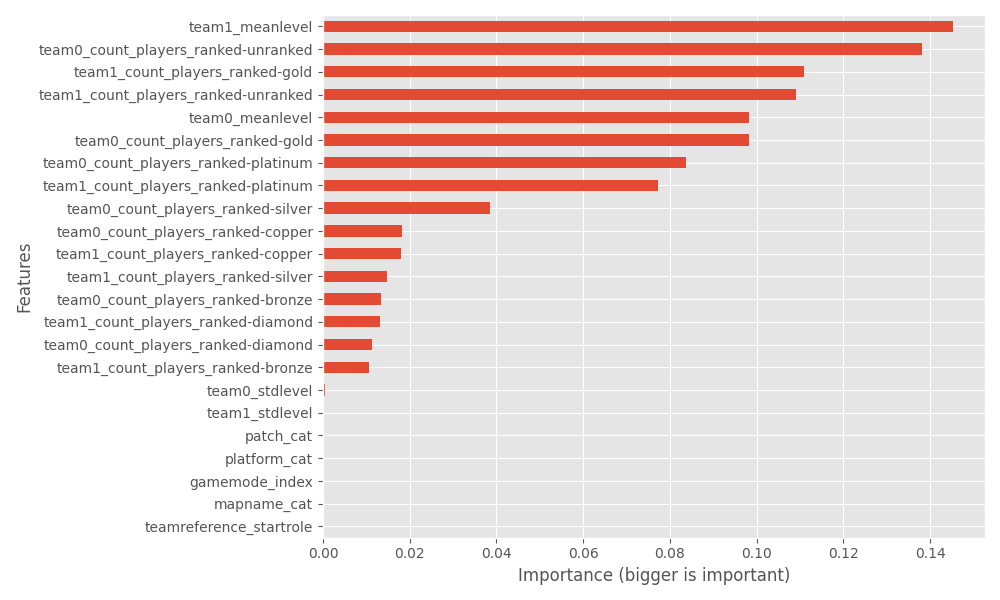

In [119]:
%matplot plt

In [63]:
# Make predictions on test data. model is the model with combination of parameters that performed best.
dfs_prediction = model.transform(dfs_testing).persist()
dfs_prediction.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

119218

In [73]:
dfs_prediction.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['matchid', 'features', 'label', 'prediction']

In [64]:
dfs_prediction.select('prediction').rdd.min()[0], dfs_prediction.select('prediction').rdd.max()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.2614683240479132, 0.8026780918961052)

In [65]:
# Compute the evaluation
evaluator = RegressionEvaluator()
evaluator.evaluate(dfs_prediction)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.4816733031251485

In [66]:
# Get a reference to compare the predictor
dfs_prediction_custom = dfs_prediction.withColumn('prediction', F.lit(0.5))
evaluator.evaluate(dfs_prediction_custom)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.49999999999999994

In [70]:
# Build a distribution of the prediction
dfp_value_predictions = dfs_prediction.select(['prediction']).toPandas()
fig,ax = plt.subplots(figsize = figsize)
ax = sns.distplot(dfp_value_predictions['prediction'])
plt.xlabel("Probability of victory")
fig.tight_layout()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/tmp/1617570361557-0/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

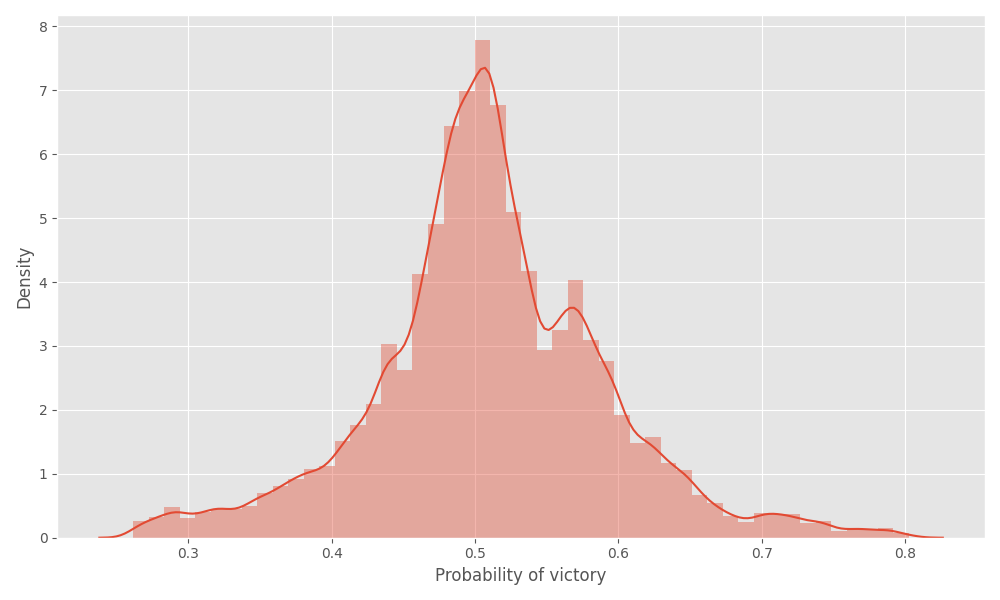

In [71]:
%matplot plt

In [87]:
# Now just trying to see global metrics in comparison of this prediction
# Build a distribution of the prediction
fig,ax = plt.subplots(figsize = figsize)
dfp_toplot = dfs_prediction.join(dfs_matches_stats.select(['matchid','deltateam_meanlevel']), on='matchid').select(['prediction', 'deltateam_meanlevel']).toPandas()
dfp_toplot.plot(ax=ax, x='prediction', y='deltateam_meanlevel', kind='scatter', alpha=0.1)
plt.xlabel("Probability of victory")
plt.ylabel("Difference of average level between teams")
fig.tight_layout()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

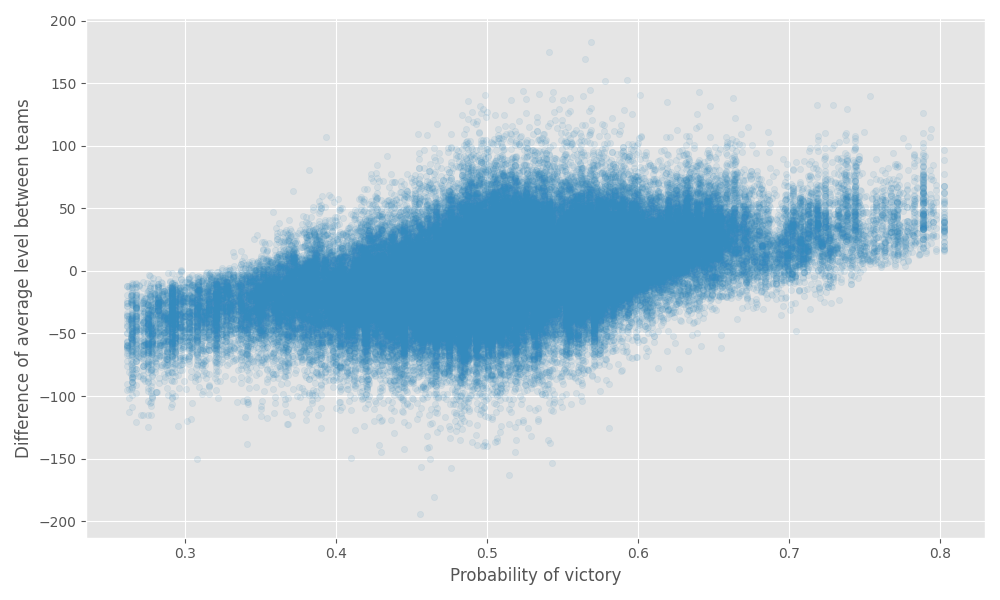

In [89]:
%matplot plt

In [92]:
fig,ax = plt.subplots(figsize = figsize)
dfp_toplot = dfs_prediction.join(dfs_matches_stats.select(['matchid','deltateam_skillranks_ed']), on='matchid').select(['prediction', 'deltateam_skillranks_ed']).toPandas()
dfp_toplot.plot(ax=ax, x='prediction', y='deltateam_skillranks_ed', kind='scatter', alpha=0.1)
plt.xlabel("Probability of victory")
plt.ylabel("Euclidian distance between skillrank features")
fig.tight_layout()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

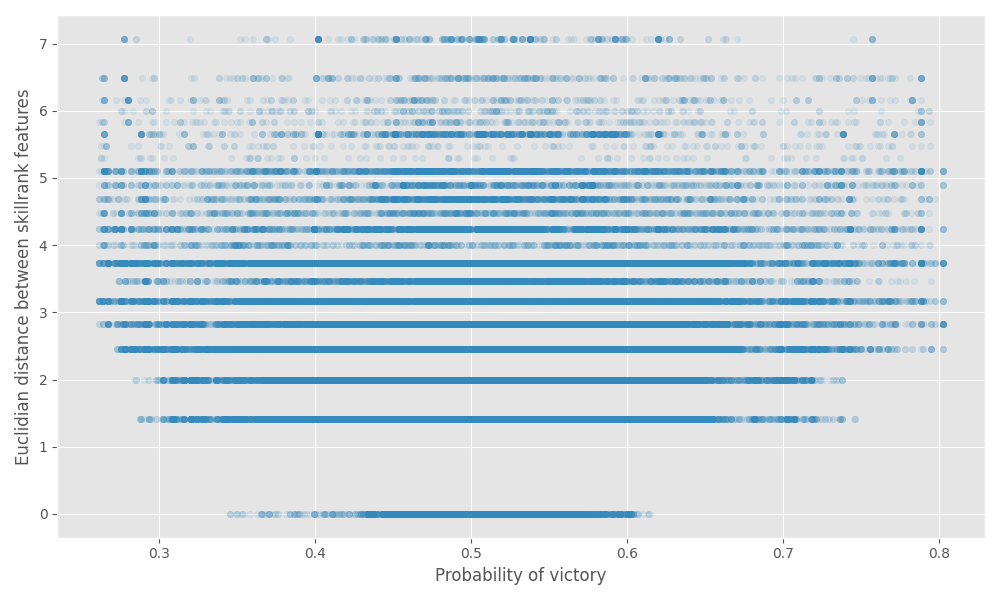

In [93]:
%matplot plt

## Debug

In [78]:
dfp_toplot.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   prediction  deltateam_meanlevel
0    0.486639           -27.399994
1    0.441843           -70.000000
2    0.605296             0.000000
3    0.601487            22.600002
4    0.495254           -28.799995